# Solve the inventory management problem using Python/Numpy

John Stachurski
Sun 13 Aug 2023 04:25:41

In [1]:
from model import *
from dp_algos import *
from plot_code import *

# Operators and functions 

In [2]:
def B(v, model):
    """
    B(y, z, a, v) = r(y, a) + β(z) Σ_{y′, z′} v(y′, z′) R(y, a, y′) Q(z, z′)

    """
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)

    # broadcasting over    (y,   z,   a)
    r = np.reshape(r,      (n_y, 1,   n_y))
    β = np.reshape(z_vals, (1,   n_z, 1))

    # broadcasting over (y,   z,   a,   yp,   zp)
    R = np.reshape(R,   (n_y, 1,   n_y, n_y,  1))
    Q = np.reshape(Q,   (1,   n_z, 1,   1,    n_z))
    v = np.reshape(v,   (1,   1,   1,   n_y,  n_z))

    Ev = np.sum(v * R * Q, axis=(3, 4))
    return r + β * Ev

In [3]:
def compute_r_σ(σ, model):
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)
    z_idx = range(n_z)
    # Create r_σ with indices (y,   z)
    y = np.reshape(y_vals,    (n_y, 1))
    z = np.reshape(z_idx,     (1,   n_z))
    r_σ = r[y, σ[y, z]]
    return r_σ

In [4]:
def compute_R_σ(σ, model):
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)
    z_idx = range(n_z)
    # Create R_σ with indices (y,   z,   yp)
    y  = np.reshape(y_vals,   (n_y, 1,   1))
    yp = np.reshape(y_vals,   (1,   1,   n_y))
    z  = np.reshape(z_idx,    (1,   n_z, 1))
    R_σ = R[y, σ[y, z], yp]
    return R_σ 

In [5]:
def compute_L_σ(σ, model):
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)
    R_σ = compute_R_σ(σ, model)
    # Create L_σ with indices (y,   z,   yp,  zp)
    β   = np.reshape(z_vals,  (1,   n_z, 1,   1))
    R_σ = np.reshape(R_σ,     (n_y, n_z, n_y, 1))
    Q   = np.reshape(Q,       (1,   n_z, 1,   n_z))
    L_σ = β * R_σ * Q
    return L_σ

In [6]:
def T(v, model):
    "The Bellman operator."
    return np.max(B(v, model), axis=2)

In [7]:
def get_greedy(v, model):
    "Get a v-greedy policy."
    return np.argmax(B(v, model), axis=2)

In [8]:
def T_σ(v, σ, model):
    "The policy operator."
    r, R, y_vals, z_vals, Q = model.arrays
    n_z, n_y = len(z_vals), len(y_vals)
    r_σ = compute_r_σ(σ, model)
    L_σ = compute_L_σ(σ, model)
    v = np.reshape(v, (1, 1, n_y, n_z))
    return r_σ + np.sum(L_σ * v, axis=(2, 3))

In [9]:
def get_value(σ, model):
    r, R, y_vals, z_vals, Q = model.arrays
    n_z, n_y = len(z_vals), len(y_vals)
    r_σ = compute_r_σ(σ, model)
    L_σ = compute_L_σ(σ, model)
    # Reshape for matrix algebra
    n = n_z * n_y
    L_σ = np.reshape(L_σ, (n, n))
    r_σ = np.reshape(r_σ, n)
    # Apply matrix operations --- solve for the value of σ 
    I = np.identity(n)
    v_σ = np.linalg.solve(I - L_σ,  r_σ)
    # Return as multi-index array
    return np.reshape(v_σ, (n_y, n_z))

# Custom solvers 

In [10]:
def solve_model_numpy(model, algorithm="OPI", **kwargs):
    """
    General purpose solver. 

    algorithm : OPI, VFI or HPI

    """

    # Set up
    n_y, n_z = model.sizes
    v_init = np.zeros((n_y, n_z))

    # Solve
    print(f"Solving model via using {algorithm}.")
    match algorithm:
        case "OPI":
            solver = optimistic_policy_iteration
            args = (v_init, 
                lambda v, σ: T_σ(v, σ, model), 
                lambda v: get_greedy(v, model))
        case "HPI":
            solver = howard_policy_iteration
            args = (v_init, 
                lambda σ: get_value(σ, model), 
                lambda v: get_greedy(v, model))
        case "VFI":
            solver = value_function_iteration
            args = (v_init, 
                lambda v: T(v, model), 
                lambda v: get_greedy(v, model))
        case _:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    v_star, σ_star = solver(*args, **kwargs)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [11]:
def test_timing_numpy(model,
                      m_vals=range(1, 100, 20),
                      figname="numpy_timing.pdf",
                      savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_numpy(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_numpy(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = np.max(np.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_numpy(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = np.max(np.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

# Simulations and plots 

In [12]:
model = create_sdd_inventory_model()

Building model with ρ(L) = 0.9751716609507842


## Solve by VFI

In [13]:
v_star, σ_star = solve_model_numpy(model, algorithm="VFI")

Solving model via using VFI.


Completed iteration 25 with error 0.561291818742589.


Completed iteration 50 with error 0.37760311527087964.


Completed iteration 75 with error 0.22781271574231.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 125 with error 0.06841133244554953.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 175 with error 0.014717604780905447.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 225 with error 0.0041302272069572155.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 275 with error 0.0011779116780914478.


Completed iteration 300 with error 0.0006285733275817051.


Completed iteration 325 with error 0.0003353535262320406.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 375 with error 9.54245640016893e-05.


Completed iteration 400 with error 5.08987992517973e-05.


Completed iteration 425 with error 2.714849425444754e-05.


Completed iteration 450 with error 1.448034407758314e-05.


Completed iteration 475 with error 7.723411918902912e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 525 with error 2.1971809971432776e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


Terminated successfully in 558 iterations.


TOC: Elapsed: 0:10:52.62
Solved model using VFI in 652.62763 seconds.


## Solve by HPI

In [14]:
v_star, σ_star = solve_model_numpy(model, algorithm="HPI")

Solving model via using HPI.


Concluded loop 1 with error 66.


Concluded loop 2 with error 60.


Concluded loop 3 with error 32.


Concluded loop 4 with error 32.


Concluded loop 5 with error 24.


Concluded loop 6 with error 24.


Concluded loop 7 with error 24.


Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:11.44
Solved model using HPI in 11.44554 seconds.


## Solve by OPI

In [15]:
v_star, σ_star = solve_model_numpy(model, algorithm="OPI")

Solving model via using OPI.


Completed iteration 10 with error 0.0039891442849224745.


TOC: Elapsed: 0:00:39.82
Solved model using OPI in 39.82922 seconds.


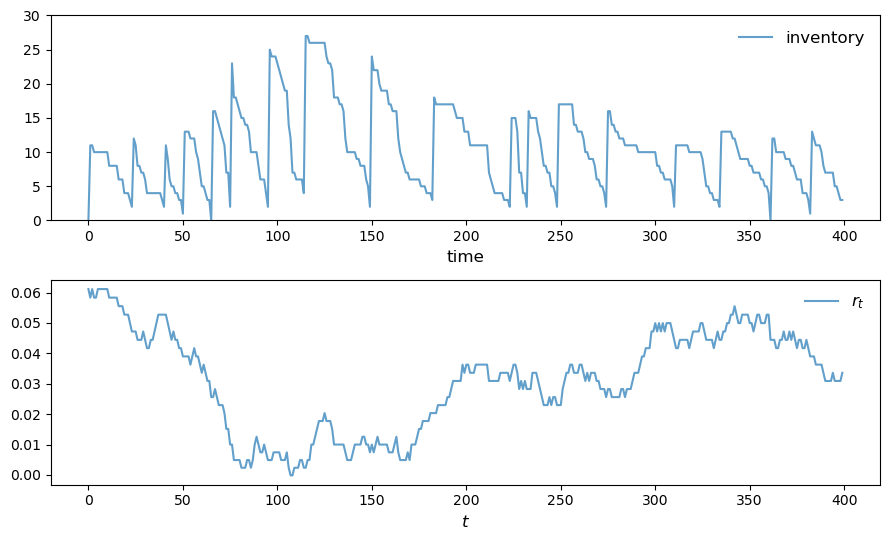

In [16]:
plot_ts(model, σ_star, figname="numpy_ts.pdf", savefig=False)

## Test timing

Solving model via using HPI.


Concluded loop 1 with error 66.


Concluded loop 2 with error 60.


Concluded loop 3 with error 32.


Concluded loop 4 with error 32.


Concluded loop 5 with error 24.


Concluded loop 6 with error 24.


Concluded loop 7 with error 24.


Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:11.58
Solved model using HPI in 11.58197 seconds.
TOC: Elapsed: 0:00:11.58
Solving model via using VFI.


Completed iteration 25 with error 0.561291818742589.


Completed iteration 50 with error 0.37760311527087964.


Completed iteration 75 with error 0.22781271574231.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 125 with error 0.06841133244554953.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 175 with error 0.014717604780905447.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 225 with error 0.0041302272069572155.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 275 with error 0.0011779116780914478.


Completed iteration 300 with error 0.0006285733275817051.


Completed iteration 325 with error 0.0003353535262320406.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 375 with error 9.54245640016893e-05.


Completed iteration 400 with error 5.08987992517973e-05.


Completed iteration 425 with error 2.714849425444754e-05.


Completed iteration 450 with error 1.448034407758314e-05.


Completed iteration 475 with error 7.723411918902912e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 525 with error 2.1971809971432776e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


Terminated successfully in 558 iterations.


TOC: Elapsed: 0:10:37.01
Solved model using VFI in 637.01235 seconds.
TOC: Elapsed: 0:10:37.01
Solving model via using OPI.


Completed iteration 10 with error 0.6480358762326102.


Completed iteration 20 with error 0.5949305169605914.


Completed iteration 30 with error 0.5251459484602314.


Completed iteration 40 with error 0.4502411260545358.


Completed iteration 50 with error 0.3776031152708761.


Completed iteration 60 with error 0.3113925226324419.


Completed iteration 70 with error 0.25348563920216094.


Completed iteration 80 with error 0.20428999885410093.


Completed iteration 90 with error 0.1633451023325989.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 110 with error 0.10191243757392954.


Completed iteration 120 with error 0.07865530805722187.


Completed iteration 130 with error 0.05904856720101037.


Completed iteration 140 with error 0.043112055223730295.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 160 with error 0.022647420777794025.


Completed iteration 170 with error 0.01689273636191757.


Completed iteration 180 with error 0.012879757243666745.


Completed iteration 190 with error 0.009949277899586662.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 210 with error 0.006014172995399747.


Completed iteration 220 with error 0.0046814651373523475.


Completed iteration 230 with error 0.0036437639326720728.


Completed iteration 240 with error 0.002835651991937027.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 260 with error 0.001716684887533404.


Completed iteration 270 with error 0.001335508294864951.


Completed iteration 280 with error 0.001038896093632502.


Completed iteration 290 with error 0.0008081157057162613.


Completed iteration 300 with error 0.0006285733275817051.


Completed iteration 310 with error 0.0004889036860333817.


Completed iteration 320 with error 0.00038025837859834155.


Completed iteration 330 with error 0.00029575008841931094.


Completed iteration 340 with error 0.00023001891724305779.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 360 with error 0.00013913120260866663.


Completed iteration 370 with error 0.00010820542954803614.


Completed iteration 380 with error 8.415320764498802e-05.


Completed iteration 390 with error 6.544703997946044e-05.


Completed iteration 400 with error 5.08987992517973e-05.


Completed iteration 410 with error 3.958436084161576e-05.


Completed iteration 420 with error 3.0784961055019266e-05.


Completed iteration 430 with error 2.3941573402908034e-05.


Completed iteration 440 with error 1.861941635183939e-05.


Completed iteration 450 with error 1.4480344070477713e-05.


Completed iteration 460 with error 1.1261370822523986e-05.


Completed iteration 470 with error 8.757966710959408e-06.


Completed iteration 480 with error 6.81106531885689e-06.


Completed iteration 490 with error 5.296958661915596e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 510 with error 3.2036803787605095e-06.


Completed iteration 520 with error 2.491496637446744e-06.


Completed iteration 530 with error 1.9376322057951256e-06.


Completed iteration 540 with error 1.506892658653669e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


TOC: Elapsed: 0:11:1.97
Solved model using OPI in 661.97691 seconds.
TOC: Elapsed: 0:11:1.97
Solving model via using OPI.


Completed iteration 10 with error 0.23575181290819813.


Completed iteration 20 with error 0.001229255528706119.


Completed iteration 30 with error 6.262373965171264e-06.


TOC: Elapsed: 0:00:54.41
Solved model using OPI in 54.41828 seconds.
TOC: Elapsed: 0:00:54.41
Solving model via using OPI.


Completed iteration 10 with error 0.021172106956534265.


Completed iteration 20 with error 6.989141141389155e-07.


TOC: Elapsed: 0:00:40.15
Solved model using OPI in 40.15134 seconds.
TOC: Elapsed: 0:00:40.15
Solving model via using OPI.


Completed iteration 10 with error 0.002919326747964135.


TOC: Elapsed: 0:00:38.57
Solved model using OPI in 38.57131 seconds.
TOC: Elapsed: 0:00:38.57
Solving model via using OPI.


Completed iteration 10 with error 0.00035446903334701574.


TOC: Elapsed: 0:00:36.72
Solved model using OPI in 36.72083 seconds.
TOC: Elapsed: 0:00:36.72


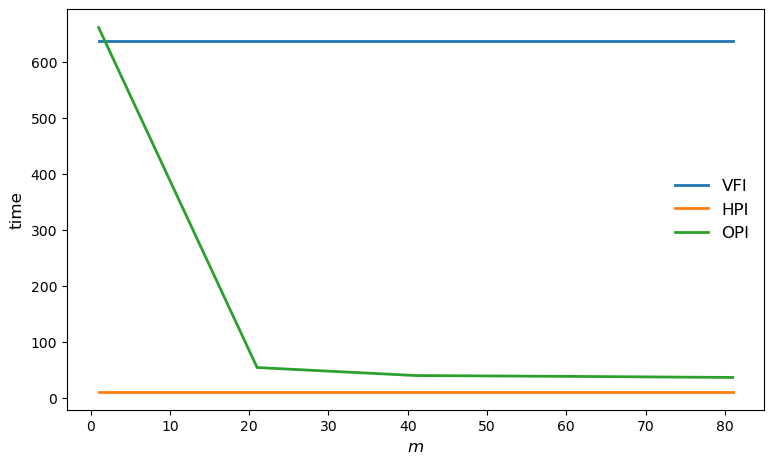

In [17]:
hpi_time, vfi_time, opi_times = test_timing_numpy(model)